# Setup Enviornment

In [1]:
from monai.utils import (
    first, 
    set_determinism, 
    ensure_tuple
)
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    RandRotate90d,
    RandShiftIntensityd,
    RandFlipd,
    RandGaussianNoised,
    RandAdjustContrastd,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
    AddChanneld,
    RandGaussianSharpend,
    RandGaussianSmoothd,
    RandHistogramShiftd,
    OneOf,
    Rand3DElasticd,
    Rand3DElastic,
    RandGridDistortiond,
    RandSpatialCropSamplesd,
    FillHoles,
    LabelFilter,
    LabelToContour
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNETR
from monai.networks.layers import Norm
from monai.metrics import (
    DiceMetric, 
    HausdorffDistanceMetric
)
from monai.losses import (
    DiceLoss, 
    DiceCELoss, 
    DiceFocalLoss,
    FocalLoss
)
from monai.inferers import sliding_window_inference
from monai.data import (
    CacheDataset, 
    DataLoader, 
    Dataset, 
    decollate_batch, 
    ImageReader
)
from monai.data.image_reader import WSIReader
from monai.config import (
    print_config, 
    KeysCollection, 
    PathLike
)
from monai.apps import download_and_extract
import torch
from torchio.transforms import (
    RandomAffine
)
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from numpy import random
from pathlib import Path
import re
from skimage import io
from typing import (
    Optional, 
    Union, 
    Sequence, 
    Callable, 
    Dict, 
    List
)
from monai.data.utils import is_supported_format
from monai. data.image_reader import (
    _copy_compatible_dict, 
    _stack_images
)
from nibabel.nifti1 import Nifti1Image
from PIL import Image
import numpy as np
from tqdm import tqdm
import pickle
import pandas as pd
from mlflow import log_metric, log_param, log_artifacts, set_experiment, start_run, end_run
import warnings
warnings.filterwarnings('ignore')

In [2]:
print_config()

MONAI version: 0.8.0
Numpy version: 1.21.4
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.4.0
Tensorboard version: 2.7.0
gdown version: 4.2.0
TorchVision version: 0.10.0
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.0
einops version: 0.3.2
transformers version: 4.15.0
mlflow version: 1.22.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
class TIFFReader(ImageReader):
    
    def __init__(self, npz_keys: Optional[KeysCollection] = None, channel_dim: Optional[int] = None, **kwargs):
        super().__init__()
        if npz_keys is not None:
            npz_keys = ensure_tuple(npz_keys)
        self.npz_keys = npz_keys
        self.channel_dim = channel_dim
        self.kwargs = kwargs
    
    def verify_suffix(self, filename: Union[Sequence[PathLike], PathLike]) -> bool:
        """
        Verify whether the specified file or files format is supported by Numpy reader.

        Args:
            filename: file name or a list of file names to read.
                if a list of files, verify all the suffixes.
        """
        suffixes: Sequence[str] = ["tif", "tiff"]
        return is_supported_format(filename, suffixes)

    def read(self, data: Union[Sequence[PathLike], PathLike], **kwargs):
        """
        Read image data from specified file or files, it can read a list of `no-channel` data files
        and stack them together as multi-channels data in `get_data()`.
        Note that the returned object is Numpy array or list of Numpy arrays.

        Args:
            data: file name or a list of file names to read.
            kwargs: additional args for `numpy.load` API except `allow_pickle`, will override `self.kwargs` for existing keys.
                More details about available args:
                https://numpy.org/doc/stable/reference/generated/numpy.load.html

        """
        img_: List[Nifti1Image] = []

        filenames: Sequence[PathLike] = ensure_tuple(data)
        kwargs_ = self.kwargs.copy()
        kwargs_.update(kwargs)
        for name in filenames:
            img = io.imread(name, **kwargs_)
            img = img.astype('float32')
            if len(img.shape)==4:
                img = np.swapaxes(img,0,1)
                img = np.swapaxes(img,1,3)
            if len(img.shape)==3:
                img = numpy.expand_dims(img, axis)
            img_.append(img)
        return img_ if len(img_) > 1 else img_[0]
    
    def get_data(self, img):
        """
        Extract data array and meta data from loaded image and return them.
        This function returns two objects, first is numpy array of image data, second is dict of meta data.
        It constructs `affine`, `original_affine`, and `spatial_shape` and stores them in meta dict.
        When loading a list of files, they are stacked together at a new dimension as the first dimension,
        and the meta data of the first image is used to represent the output meta data.

        Args:
            img: a Numpy array loaded from a file or a list of Numpy arrays.

        """
        img_array: List[np.ndarray] = []
        compatible_meta: Dict = {}
        if isinstance(img, np.ndarray):
            img = (img,)

        for i in ensure_tuple(img):
            header = {"affine":np.eye(5),
                     "labels": {"0": "background",
                                "1": "pial/penetrating vessel",
                                "2": "microvessel",
                                "3": "neurons"}
                     }
            if isinstance(i, np.ndarray):
                # if `channel_dim` is None, can not detect the channel dim, use all the dims as spatial_shape
                spatial_shape = np.asarray(i.shape)
                if isinstance(self.channel_dim, int):
                    spatial_shape = np.delete(spatial_shape, self.channel_dim)
                header["spatial_shape"] = spatial_shape
            img_array.append(i)
            header["original_channel_dim"] = self.channel_dim if isinstance(self.channel_dim, int) else "no_channel"
            _copy_compatible_dict(header, compatible_meta)

        return _stack_images(img_array, compatible_meta), compatible_meta

# Hyperparameters

In [4]:
parameter_file = 'hyperparameter_pickle_files/parameters436.pickle'

In [5]:
experiment = re.sub('.pickle',
                    '',
                    re.sub('hyperparameter_pickle_files/parameters',
                           '',
                           parameter_file
                          )
                   )
experiment  = experiment + '_vessel_class'
#set_experiment("TBI_UNet_adam_optimizer")

In [6]:
experiment

'436_vessel_class'

In [7]:
with open(parameter_file, 'rb') as handle:
    params = pickle.load(handle)
params["batch_size"] = 1
params['crop_size'] = (128,128,128)

In [8]:
for i in params.keys():
    log_param(i,params[i])

# setup directory to save enviornment

In [9]:
directory = re.sub('.pickle',
                   '',
                   re.sub('hyperparameter_pickle_files/parameters',
                          'training_models/',
                           parameter_file
                         )
                  )
directory = directory + '_vessel_class'
try:
    os.mkdir(directory)
except OSError as error:
    print(error) 
#log_artifacts(directory)
print(directory)

[Errno 17] File exists: 'training_models/436_vessel_class'
training_models/436_vessel_class


In [10]:
directory

'training_models/436_vessel_class'

# get train and validate data

In [11]:
#make list of data dictionaries
train_labels_path = Path('../TBI/PV-cap sep model/')#labels path
train_labels = list(train_labels_path.glob('*_sub1.tiff'))#get label images
train_labels = sorted([x.as_posix() for x in train_labels])#sort
train_images = [re.sub("_Simple Segmentation_sub1.tiff","_withOutput.tif",i) for i in train_labels]
train_images_paths = [Path(i) for i in train_images]
#combine images and labels into monai dictionary format
data_dicts = [
    {"image":image_name, "label":label_name}
    for image_name, label_name in zip(train_images,train_labels)
]


In [12]:
data_dicts

[{'image': '../TBI/PV-cap sep model/XYZres018_0001_withOutput.tif',
  'label': '../TBI/PV-cap sep model/XYZres018_0001_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/PV-cap sep model/XYZres032_withOutput.tif',
  'label': '../TBI/PV-cap sep model/XYZres032_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/PV-cap sep model/XYZres037_withOutput.tif',
  'label': '../TBI/PV-cap sep model/XYZres037_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/PV-cap sep model/XYZres042_0001_withOutput.tif',
  'label': '../TBI/PV-cap sep model/XYZres042_0001_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/PV-cap sep model/XYZres050_withOutput.tif',
  'label': '../TBI/PV-cap sep model/XYZres050_Simple Segmentation_sub1.tiff'}]

In [26]:
mouse_ids_path = Path('../TBI/raw')#each mouse has its own folder with raw data in it
mouse_ids = list(mouse_ids_path.glob('*'))#grab molder names/mouse ids
images = sorted([y.name for y in train_images_paths])#sort
#get mouse id corresponding to each image i have labels for
mouse_ids_with_raw_tiff = []
for i in mouse_ids:
    for j in images:
        j = re.sub('_withOutput','',j)
        if len(list(i.glob(j))) !=0:
            mouse_ids_with_raw_tiff.append(list(i.glob(j)))
print(mouse_ids_with_raw_tiff)
#flatten the list and sort
mouse_ids_with_raw_tiff_flat = [item for sublist in mouse_ids_with_raw_tiff for item in sublist]
mouse_ids_with_raw_tiff_flat = sorted(mouse_ids_with_raw_tiff_flat)
print(mouse_ids_with_raw_tiff_flat)

[[PosixPath('../TBI/raw/vbm09 Mar 28 2020/XYZres037.tif')], [PosixPath('../TBI/raw/vbm05 Feb 28 2020/XYZres018_0001.tif')], [PosixPath('../TBI/raw/vbm08 Mar 27 2020/XYZres032.tif')], [PosixPath('../TBI/raw/vbm11 Apr 04 2020/XYZres050.tif')], [PosixPath('../TBI/raw/vbm10 Apr 03 2020/XYZres042_0001.tif')]]
[PosixPath('../TBI/raw/vbm05 Feb 28 2020/XYZres018_0001.tif'), PosixPath('../TBI/raw/vbm08 Mar 27 2020/XYZres032.tif'), PosixPath('../TBI/raw/vbm09 Mar 28 2020/XYZres037.tif'), PosixPath('../TBI/raw/vbm10 Apr 03 2020/XYZres042_0001.tif'), PosixPath('../TBI/raw/vbm11 Apr 04 2020/XYZres050.tif')]


In [17]:
images

['XYZres018_0001_withOutput.tif',
 'XYZres032_withOutput.tif',
 'XYZres037_withOutput.tif',
 'XYZres042_0001_withOutput.tif',
 'XYZres050_withOutput.tif']

In [27]:
#shuffle mouse ids for a 15/4/6 split train/val/test by mouse id
mouse_ids_present = [i.parent.name for i in mouse_ids_with_raw_tiff_flat]
mouse_ids_present = sorted(list(np.unique(mouse_ids_present)))
np.random.seed(643)
np.random.shuffle(mouse_ids_present)
mouse_ids_present
train = mouse_ids_present[:3]
#log_param('train_set',' '.join(train))
val = mouse_ids_present[-2:]
#log_param('val_set',' '.join(val))
test = mouse_ids_present[-2:]

In [28]:
train

['vbm05 Feb 28 2020', 'vbm08 Mar 27 2020', 'vbm10 Apr 03 2020']

In [29]:
mouse_ids_present

['vbm05 Feb 28 2020',
 'vbm08 Mar 27 2020',
 'vbm10 Apr 03 2020',
 'vbm09 Mar 28 2020',
 'vbm11 Apr 04 2020']

In [38]:
train_files = []
val_files = []
test_files = []
for i in train:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if re.sub(".tif","_withOutput.tif",j.name) in k["image"]:
                    train_files.append(k)
for i in val:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if re.sub(".tif","_withOutput.tif",j.name) in k["image"]:
                    val_files.append(k)
for i in test:
    for j in mouse_ids_with_raw_tiff_flat:
        if i in j.as_posix():
            for k in data_dicts:
                if re.sub(".tif","_withOutput.tif",j.name) in k["image"]:
                    test_files.append(k)

In [39]:
train_files

[{'image': '../TBI/PV-cap sep model/XYZres018_0001_withOutput.tif',
  'label': '../TBI/PV-cap sep model/XYZres018_0001_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/PV-cap sep model/XYZres032_withOutput.tif',
  'label': '../TBI/PV-cap sep model/XYZres032_Simple Segmentation_sub1.tiff'},
 {'image': '../TBI/PV-cap sep model/XYZres042_0001_withOutput.tif',
  'label': '../TBI/PV-cap sep model/XYZres042_0001_Simple Segmentation_sub1.tiff'}]

# Set deterministic training for reproducability

In [40]:
set_determinism(seed=12)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [41]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], reader = TIFFReader(channel_dim = 0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.01, 1.01, 0.3787), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1024,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        AsDiscreted(keys="label",
                   rounding='torchrounding',
                   to_onehot=True),
        #random cropping
        RandSpatialCropSamplesd(
            keys=['image','label'],
            num_samples = 4,#params['N_crops'],
            roi_size = params['crop_size'],
            random_size = False
        ),
        #Deformation_transforms
        OneOf(transforms=[Rand3DElasticd(keys = ["image","label"],
                                        sigma_range = params['Rand3DElasticd_sigma_range'],
                                        magnitude_range = params['Rand3DElasticd_magnitude_range'],
                                        prob = params["deformation_transforms_prob"],
                                        mode = ["bilinear","nearest"]),
                          RandGridDistortiond(keys = ["image","label"],
                                             num_cells = params['RandGridDistortiond_num_cells'],
                                             prob = params["deformation_transforms_prob"],
                                             distort_limit = params['RandGridDistortiond_distort_limit'],
                                             mode = ["bilinear","nearest"]
                                             )
                         ]
             ),
        #Intensity_Transforms
        OneOf(transforms = [RandShiftIntensityd(keys = ["image"],
                                                offsets = params['RandShiftIntensityd_offsets'],
                                                prob = params["intensity_transform_probability"]),
                            RandAdjustContrastd(keys = ["image"],
                                                prob = params["intensity_transform_probability"],
                                                gamma = params['RandAdjustContrastd_gamma']),
                            RandHistogramShiftd(keys = ["image"],
                                                prob = params["intensity_transform_probability"],
                                                num_control_points = params['RandHistogramShiftd_num_control_points'])
                           ]
             ),
        #Gaussian_Transforms
        OneOf(transforms = [RandGaussianSharpend(keys = ["image"],
                                                 prob = params["gaussian_transform_probability"]),
                            RandGaussianSmoothd(keys = ["image"],
                                                prob = params["gaussian_transform_probability"]),
                            RandGaussianNoised(keys = ["image"],
                                               prob = params["gaussian_transform_probability"],
                                               mean = params['RandGaussianNoised_mean'],
                                               std = params['RandGaussianNoised_std'])
                           ]
             ),
        #rottion+flip_transforms
        RandRotate90d(
            keys = ["image", "label"],
            prob = params['rotation_flip_transforms_probability'],
            max_k = 3,
            spatial_axes=(0,1)
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [0],
            prob = params['rotation_flip_transforms_probability'],
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [1],
            prob = params['rotation_flip_transforms_probability'],
        ),
        RandFlipd(
            keys = ["image", "label"],
            spatial_axis = [2],
            prob = params['rotation_flip_transforms_probability'],
        ),
        #random affine
        RandomAffine(
            include=["image", "label"], 
            p=params["RandomAffine_probability"], 
            degrees=params["RandomAffine_degrees"], 
            scales=params["RandomAffine_scales"],
            translation=params["RandomAffine_translation"],
            center='image'
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"],reader = TIFFReader(channel_dim = 0)),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.01, 1.01, 0.3787), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=0, a_max=1024,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        AsDiscreted(keys="label",
                   rounding='torchrounding',
                   to_onehot=True),
        EnsureTyped(keys=["image", "label"]),
    ]
)

# Check transforms in DataLoader

image shape: torch.Size([5, 507, 507, 252]), label shape: torch.Size([1, 507, 507, 252])


TypeError: Invalid shape (507, 507, 6) for image data

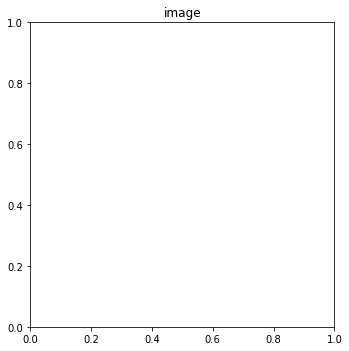

In [42]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0], check_data["label"][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [ :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = torch.transpose(image[:,:, :, 80],0,2)
img2 = img2.cpu().detach().numpy()
img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2, cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = torch.transpose(label[:,:, :, 80],0,2)
img3 = img3.cpu().detach().numpy()
plt.imshow(img3)
plt.show()


In [22]:
label

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         ...,

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [43]:
!nvidia-smi

Fri Aug 12 13:30:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:C1:00.0 Off |                    0 |
| N/A   30C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
#!ps aux | grep python

In [45]:
#!kill 58652316

In [46]:
train_ds = CacheDataset(
    data = train_files, 
    transform = train_transforms,
    cache_rate = 1, 
    num_workers = 4
)
# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(
    train_ds, 
    batch_size=params["batch_size"], 
    shuffle=True, 
    num_workers=4
)

val_ds = CacheDataset(
    data = val_files, 
    transform = val_transforms, 
    cache_rate = 1, 
    num_workers = 4
)
val_loader = DataLoader(
    val_ds, 
    batch_size = 1, 
    num_workers = 4
)

#val_ds_deform = CacheDataset(
#    data=val_files, transform=val_transforms_deform, cache_rate=1.0, num_workers=4)
#val_loader_deform = DataLoader(val_ds_deform, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:12<00:00,  6.12s/it]


# Create Model, Loss, Optimizer

In [27]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
#device = torch.device("cuda:0")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNETR(
    spatial_dims=3,
    in_channels=2,
    out_channels=4,
    img_size = params['crop_size'],
    feature_size = 16,
    hidden_size = 768,
    mlp_dim = 3072,
    pos_embed = "perceptron",
    res_block=True,
    norm_name="instance",
    dropout_rate=params["dropout"]
)
model = torch.nn.DataParallel(model)
model.to(device)
#model.load_state_dict(torch.load(
#    os.path.join(directory, "best_metric_model.pth")))
loss_function = params['loss_function']

optimizer = params['optimizer'](params = model.parameters(), 
                                lr = 1e-5)#params['learning_rate'])
dice_metric = DiceMetric(
    include_background=False,
    reduction="mean"
)
#hausdorf_distance_metric = HausdorffDistanceMetric(include_background=False,
#                                                   distance_metric='euclidean')

# Execute a typical PyTorch training process

In [ ]:
random.seed(12)
max_epochs = 2000#params["max_epochs"]
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
hausdorf_distance_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True,to_onehot=4)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=4)])
for epoch in tqdm(range(max_epochs)):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    epoch_focal_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    log_metric('epoch_loss',epoch_loss, step = epoch)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = params['crop_size']
                sw_batch_size = 1
                val_outputs = sliding_window_inference(
                    val_inputs, 
                    roi_size, 
                    sw_batch_size, 
                    model
                )
                #get prediciton output
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                filled  = [FillHoles(connectivity=2)(i) for i in val_outputs]
                dice_metric(
                    y_pred = val_outputs,
                    y = val_labels
                )
                #hausdorf_distance_metric(y_pred=filled, 
                #                         y=val_labels)
                #dice metric for deformed output, and prediction on deformed raw image
            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            log_metric(
                'dice',
                metric,
                step = epoch
            )
            ##hausdorf_distance = hausdorf_distance_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            #hausdorf_distance_metric.reset()

            metric_values.append(
                metric
            )
            #hausdorf_distance_values.append(
            #    hausdorf_distance
            #)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                #torch.save(model.state_dict(), os.path.join(
                #    directory, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                #f"\ncurrent mean hausdorf distance: {hausdorf_distance:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

  0%|                                                                                                                                                  | 0/2000 [00:00<?, ?it/s]

----------
epoch 1/2000
1/3, train_loss: 2.4336
2/3, train_loss: 2.4543


  0%|                                                                                                                                        | 1/2000 [00:13<7:40:41, 13.83s/it]

3/3, train_loss: 2.4497
epoch 1 average loss: 2.4459
----------
epoch 2/2000
1/3, train_loss: 2.4332
2/3, train_loss: 2.4450
3/3, train_loss: 2.4449
epoch 2 average loss: 2.4410


  0%|▏                                                                                                                                      | 2/2000 [01:07<20:42:17, 37.31s/it]

saved new best metric model
current epoch: 2 current mean dice: 0.0149
best mean dice: 0.0149 at epoch: 2
----------
epoch 3/2000
1/3, train_loss: 2.4144
2/3, train_loss: 2.4627


  0%|▏                                                                                                                                      | 3/2000 [01:13<12:40:28, 22.85s/it]

3/3, train_loss: 2.4341
epoch 3 average loss: 2.4370
----------
epoch 4/2000
1/3, train_loss: 2.4261
2/3, train_loss: 2.4144
3/3, train_loss: 2.4144
epoch 4 average loss: 2.4183


  0%|▎                                                                                                                                      | 4/2000 [02:07<19:33:03, 35.26s/it]

saved new best metric model
current epoch: 4 current mean dice: 0.0149
best mean dice: 0.0149 at epoch: 4
----------
epoch 5/2000
1/3, train_loss: 2.4504
2/3, train_loss: 2.4320


  0%|▎                                                                                                                                      | 5/2000 [02:12<13:29:09, 24.34s/it]

3/3, train_loss: 2.4071
epoch 5 average loss: 2.4298
----------
epoch 6/2000
1/3, train_loss: 2.4102
2/3, train_loss: 2.4280
3/3, train_loss: 2.4057
epoch 6 average loss: 2.4146


  0%|▍                                                                                                                                      | 6/2000 [03:06<19:00:49, 34.33s/it]

saved new best metric model
current epoch: 6 current mean dice: 0.0152
best mean dice: 0.0152 at epoch: 6
----------
epoch 7/2000
1/3, train_loss: 2.3513
2/3, train_loss: 2.3915


  0%|▍                                                                                                                                      | 7/2000 [03:11<13:47:12, 24.90s/it]

3/3, train_loss: 2.3944
epoch 7 average loss: 2.3790
----------
epoch 8/2000
1/3, train_loss: 2.4110
2/3, train_loss: 2.4208
3/3, train_loss: 2.3825
epoch 8 average loss: 2.4048


  0%|▌                                                                                                                                      | 8/2000 [04:06<18:59:27, 34.32s/it]

saved new best metric model
current epoch: 8 current mean dice: 0.0156
best mean dice: 0.0156 at epoch: 8
----------
epoch 9/2000
1/3, train_loss: 2.4367
2/3, train_loss: 2.3970


  0%|▌                                                                                                                                      | 9/2000 [04:10<13:52:10, 25.08s/it]

3/3, train_loss: 2.3999
epoch 9 average loss: 2.4112
----------
epoch 10/2000
1/3, train_loss: 2.3633
2/3, train_loss: 2.3847
3/3, train_loss: 2.3331
epoch 10 average loss: 2.3604


  0%|▋                                                                                                                                     | 10/2000 [05:05<18:49:51, 34.07s/it]

saved new best metric model
current epoch: 10 current mean dice: 0.0162
best mean dice: 0.0162 at epoch: 10
----------
epoch 11/2000
1/3, train_loss: 2.3953
2/3, train_loss: 2.3784


  1%|▋                                                                                                                                     | 11/2000 [05:09<13:50:32, 25.05s/it]

3/3, train_loss: 2.3498
epoch 11 average loss: 2.3745
----------
epoch 12/2000
1/3, train_loss: 2.3729
2/3, train_loss: 2.3683
3/3, train_loss: 2.3495
epoch 12 average loss: 2.3636


  1%|▊                                                                                                                                     | 12/2000 [06:03<18:42:46, 33.89s/it]

saved new best metric model
current epoch: 12 current mean dice: 0.0172
best mean dice: 0.0172 at epoch: 12
----------
epoch 13/2000
1/3, train_loss: 2.3723
2/3, train_loss: 2.3645


  1%|▊                                                                                                                                     | 13/2000 [06:09<13:56:33, 25.26s/it]

3/3, train_loss: 2.3541
epoch 13 average loss: 2.3636
----------
epoch 14/2000
1/3, train_loss: 2.3458
2/3, train_loss: 2.3260
3/3, train_loss: 2.3468
epoch 14 average loss: 2.3395


  1%|▉                                                                                                                                     | 14/2000 [07:03<18:42:01, 33.90s/it]

saved new best metric model
current epoch: 14 current mean dice: 0.0186
best mean dice: 0.0186 at epoch: 14
----------
epoch 15/2000
1/3, train_loss: 2.3310
2/3, train_loss: 2.3122


  1%|█                                                                                                                                     | 15/2000 [07:08<14:01:53, 25.45s/it]

3/3, train_loss: 2.3428
epoch 15 average loss: 2.3287
----------
epoch 16/2000
1/3, train_loss: 2.3490
2/3, train_loss: 2.3105
3/3, train_loss: 2.3592
epoch 16 average loss: 2.3396


  1%|█                                                                                                                                     | 16/2000 [08:03<18:55:38, 34.34s/it]

saved new best metric model
current epoch: 16 current mean dice: 0.0205
best mean dice: 0.0205 at epoch: 16
----------
epoch 17/2000
1/3, train_loss: 2.3736
2/3, train_loss: 2.3179


  1%|█▏                                                                                                                                    | 17/2000 [08:10<14:14:57, 25.87s/it]

3/3, train_loss: 2.3137
epoch 17 average loss: 2.3351
----------
epoch 18/2000
1/3, train_loss: 2.3137
2/3, train_loss: 2.3171
3/3, train_loss: 2.3471
epoch 18 average loss: 2.3259


  1%|█▏                                                                                                                                    | 18/2000 [09:05<19:11:10, 34.85s/it]

saved new best metric model
current epoch: 18 current mean dice: 0.0226
best mean dice: 0.0226 at epoch: 18
----------
epoch 19/2000
1/3, train_loss: 2.3163
2/3, train_loss: 2.2917


  1%|█▎                                                                                                                                    | 19/2000 [09:11<14:23:52, 26.16s/it]

3/3, train_loss: 2.2912
epoch 19 average loss: 2.2998
----------
epoch 20/2000
1/3, train_loss: 2.2984
2/3, train_loss: 2.2873
3/3, train_loss: 2.3374
epoch 20 average loss: 2.3077


  1%|█▎                                                                                                                                    | 20/2000 [10:06<19:04:25, 34.68s/it]

saved new best metric model
current epoch: 20 current mean dice: 0.0254
best mean dice: 0.0254 at epoch: 20
----------
epoch 21/2000
1/3, train_loss: 2.2440
2/3, train_loss: 2.3143


  1%|█▍                                                                                                                                    | 21/2000 [10:11<14:13:20, 25.87s/it]

3/3, train_loss: 2.3331
epoch 21 average loss: 2.2971
----------
epoch 22/2000
1/3, train_loss: 2.3280
2/3, train_loss: 2.2988
3/3, train_loss: 2.3432
epoch 22 average loss: 2.3233


  1%|█▍                                                                                                                                    | 22/2000 [11:05<18:49:40, 34.27s/it]

saved new best metric model
current epoch: 22 current mean dice: 0.0285
best mean dice: 0.0285 at epoch: 22
----------
epoch 23/2000
1/3, train_loss: 2.3280
2/3, train_loss: 2.2820


  1%|█▌                                                                                                                                    | 23/2000 [11:10<14:04:10, 25.62s/it]

3/3, train_loss: 2.2894
epoch 23 average loss: 2.2998
----------
epoch 24/2000
1/3, train_loss: 2.3229
2/3, train_loss: 2.2741
3/3, train_loss: 2.2760
epoch 24 average loss: 2.2910


  1%|█▌                                                                                                                                    | 24/2000 [12:05<18:45:35, 34.18s/it]

saved new best metric model
current epoch: 24 current mean dice: 0.0318
best mean dice: 0.0318 at epoch: 24
----------
epoch 25/2000
1/3, train_loss: 2.2498
2/3, train_loss: 2.2826


  1%|█▋                                                                                                                                    | 25/2000 [12:09<13:55:03, 25.37s/it]

3/3, train_loss: 2.3124
epoch 25 average loss: 2.2816
----------
epoch 26/2000
1/3, train_loss: 2.2762
2/3, train_loss: 2.3028
3/3, train_loss: 2.3074
epoch 26 average loss: 2.2955


  1%|█▋                                                                                                                                    | 26/2000 [13:04<18:41:31, 34.09s/it]

saved new best metric model
current epoch: 26 current mean dice: 0.0357
best mean dice: 0.0357 at epoch: 26
----------
epoch 27/2000
1/3, train_loss: 2.2386
2/3, train_loss: 2.2255


  1%|█▊                                                                                                                                    | 27/2000 [13:09<13:51:07, 25.27s/it]

3/3, train_loss: 2.2648
epoch 27 average loss: 2.2430
----------
epoch 28/2000
1/3, train_loss: 2.2824
2/3, train_loss: 2.2466
3/3, train_loss: 2.2467
epoch 28 average loss: 2.2586


  1%|█▉                                                                                                                                    | 28/2000 [14:02<18:24:58, 33.62s/it]

saved new best metric model
current epoch: 28 current mean dice: 0.0397
best mean dice: 0.0397 at epoch: 28
----------
epoch 29/2000
1/3, train_loss: 2.2915
2/3, train_loss: 2.2510


  1%|█▉                                                                                                                                    | 29/2000 [14:07<13:46:35, 25.16s/it]

3/3, train_loss: 2.2530
epoch 29 average loss: 2.2651
----------
epoch 30/2000
1/3, train_loss: 2.2642
2/3, train_loss: 2.2552
3/3, train_loss: 2.2363
epoch 30 average loss: 2.2519


  2%|██                                                                                                                                    | 30/2000 [15:03<18:44:31, 34.25s/it]

saved new best metric model
current epoch: 30 current mean dice: 0.0433
best mean dice: 0.0433 at epoch: 30
----------
epoch 31/2000
1/3, train_loss: 2.2573
2/3, train_loss: 2.2670


  2%|██                                                                                                                                    | 31/2000 [15:07<13:52:18, 25.36s/it]

3/3, train_loss: 2.2501
epoch 31 average loss: 2.2581
----------
epoch 32/2000
1/3, train_loss: 2.2327
2/3, train_loss: 2.2435
3/3, train_loss: 2.2640
epoch 32 average loss: 2.2467


  2%|██▏                                                                                                                                   | 32/2000 [16:02<18:37:40, 34.08s/it]

saved new best metric model
current epoch: 32 current mean dice: 0.0471
best mean dice: 0.0471 at epoch: 32
----------
epoch 33/2000
1/3, train_loss: 2.2013
2/3, train_loss: 2.2229


  2%|██▏                                                                                                                                   | 33/2000 [16:07<13:53:57, 25.44s/it]

3/3, train_loss: 2.2227
epoch 33 average loss: 2.2157
----------
epoch 34/2000
1/3, train_loss: 2.2299
2/3, train_loss: 2.1986
3/3, train_loss: 2.2503
epoch 34 average loss: 2.2263


  2%|██▎                                                                                                                                   | 34/2000 [17:03<18:56:03, 34.67s/it]

saved new best metric model
current epoch: 34 current mean dice: 0.0510
best mean dice: 0.0510 at epoch: 34
----------
epoch 35/2000
1/3, train_loss: 2.2217
2/3, train_loss: 2.2281


  2%|██▎                                                                                                                                   | 35/2000 [17:09<14:08:15, 25.90s/it]

3/3, train_loss: 2.2656
epoch 35 average loss: 2.2385
----------
epoch 36/2000
1/3, train_loss: 2.2485
2/3, train_loss: 2.2645
3/3, train_loss: 2.2076
epoch 36 average loss: 2.2402


  2%|██▍                                                                                                                                   | 36/2000 [18:03<18:51:30, 34.57s/it]

saved new best metric model
current epoch: 36 current mean dice: 0.0545
best mean dice: 0.0545 at epoch: 36
----------
epoch 37/2000
1/3, train_loss: 2.2209
2/3, train_loss: 2.2146


  2%|██▍                                                                                                                                   | 37/2000 [18:09<14:05:36, 25.85s/it]

3/3, train_loss: 2.2037
epoch 37 average loss: 2.2131
----------
epoch 38/2000
1/3, train_loss: 2.2062
2/3, train_loss: 2.1757
3/3, train_loss: 2.2244
epoch 38 average loss: 2.2021


  2%|██▌                                                                                                                                   | 38/2000 [19:04<18:51:24, 34.60s/it]

saved new best metric model
current epoch: 38 current mean dice: 0.0583
best mean dice: 0.0583 at epoch: 38
----------
epoch 39/2000
1/3, train_loss: 2.1926
2/3, train_loss: 2.2063


  2%|██▌                                                                                                                                   | 39/2000 [19:09<14:04:13, 25.83s/it]

3/3, train_loss: 2.2248
epoch 39 average loss: 2.2079
----------
epoch 40/2000
1/3, train_loss: 2.2368
2/3, train_loss: 2.1849
3/3, train_loss: 2.1616
epoch 40 average loss: 2.1944


  2%|██▋                                                                                                                                   | 40/2000 [20:05<18:58:32, 34.85s/it]

saved new best metric model
current epoch: 40 current mean dice: 0.0628
best mean dice: 0.0628 at epoch: 40
----------
epoch 41/2000
1/3, train_loss: 2.1775
2/3, train_loss: 2.2028


  2%|██▋                                                                                                                                   | 41/2000 [20:09<13:59:31, 25.71s/it]

3/3, train_loss: 2.2305
epoch 41 average loss: 2.2036
----------
epoch 42/2000
1/3, train_loss: 2.1920
2/3, train_loss: 2.1582
3/3, train_loss: 2.1950
epoch 42 average loss: 2.1817


  2%|██▊                                                                                                                                   | 42/2000 [21:05<18:54:28, 34.76s/it]

saved new best metric model
current epoch: 42 current mean dice: 0.0675
best mean dice: 0.0675 at epoch: 42
----------
epoch 43/2000
1/3, train_loss: 2.1745
2/3, train_loss: 2.1746


  2%|██▉                                                                                                                                   | 43/2000 [21:09<13:53:15, 25.55s/it]

3/3, train_loss: 2.1672
epoch 43 average loss: 2.1721
----------
epoch 44/2000
1/3, train_loss: 2.1698
2/3, train_loss: 2.1637
3/3, train_loss: 2.2213
epoch 44 average loss: 2.1849


  2%|██▉                                                                                                                                   | 44/2000 [22:05<18:47:41, 34.59s/it]

saved new best metric model
current epoch: 44 current mean dice: 0.0726
best mean dice: 0.0726 at epoch: 44
----------
epoch 45/2000
1/3, train_loss: 2.2389
2/3, train_loss: 2.2196


  2%|███                                                                                                                                   | 45/2000 [22:11<14:02:03, 25.84s/it]

3/3, train_loss: 2.1807
epoch 45 average loss: 2.2130
----------
epoch 46/2000
1/3, train_loss: 2.1815
2/3, train_loss: 2.1500
3/3, train_loss: 2.1342
epoch 46 average loss: 2.1552


  2%|███                                                                                                                                   | 46/2000 [23:06<18:47:50, 34.63s/it]

saved new best metric model
current epoch: 46 current mean dice: 0.0770
best mean dice: 0.0770 at epoch: 46
----------
epoch 47/2000
1/3, train_loss: 2.1834
2/3, train_loss: 2.2137


  2%|███▏                                                                                                                                  | 47/2000 [23:10<13:55:13, 25.66s/it]

3/3, train_loss: 2.1539
epoch 47 average loss: 2.1837
----------
epoch 48/2000
1/3, train_loss: 2.1757
2/3, train_loss: 2.2014
3/3, train_loss: 2.1687
epoch 48 average loss: 2.1819


  2%|███▏                                                                                                                                  | 48/2000 [24:07<18:54:40, 34.88s/it]

saved new best metric model
current epoch: 48 current mean dice: 0.0818
best mean dice: 0.0818 at epoch: 48
----------
epoch 49/2000
1/3, train_loss: 2.1479
2/3, train_loss: 2.1762


  2%|███▎                                                                                                                                  | 49/2000 [24:13<14:16:29, 26.34s/it]

3/3, train_loss: 2.1478
epoch 49 average loss: 2.1573
----------
epoch 50/2000
1/3, train_loss: 2.1530
2/3, train_loss: 2.1572
3/3, train_loss: 2.1193
epoch 50 average loss: 2.1432


  2%|███▎                                                                                                                                  | 50/2000 [25:09<19:01:54, 35.14s/it]

saved new best metric model
current epoch: 50 current mean dice: 0.0868
best mean dice: 0.0868 at epoch: 50
----------
epoch 51/2000
1/3, train_loss: 2.1168
2/3, train_loss: 2.1356


  3%|███▍                                                                                                                                  | 51/2000 [25:13<14:01:24, 25.90s/it]

3/3, train_loss: 2.2104
epoch 51 average loss: 2.1542
----------
epoch 52/2000
1/3, train_loss: 2.1371
2/3, train_loss: 2.1474
3/3, train_loss: 2.1221
epoch 52 average loss: 2.1355


  3%|███▍                                                                                                                                  | 52/2000 [26:09<18:47:39, 34.73s/it]

saved new best metric model
current epoch: 52 current mean dice: 0.0916
best mean dice: 0.0916 at epoch: 52
----------
epoch 53/2000
1/3, train_loss: 2.1344
2/3, train_loss: 2.1836


  3%|███▌                                                                                                                                  | 53/2000 [26:14<14:00:32, 25.90s/it]

3/3, train_loss: 2.1378
epoch 53 average loss: 2.1519
----------
epoch 54/2000
1/3, train_loss: 2.0949
2/3, train_loss: 2.1539
3/3, train_loss: 2.1200
epoch 54 average loss: 2.1230


  3%|███▌                                                                                                                                  | 54/2000 [27:09<18:44:31, 34.67s/it]

saved new best metric model
current epoch: 54 current mean dice: 0.0976
best mean dice: 0.0976 at epoch: 54
----------
epoch 55/2000
1/3, train_loss: 2.1728
2/3, train_loss: 2.1635


  3%|███▋                                                                                                                                  | 55/2000 [27:15<14:02:48, 26.00s/it]

3/3, train_loss: 2.1551
epoch 55 average loss: 2.1638
----------
epoch 56/2000
1/3, train_loss: 2.1182
2/3, train_loss: 2.1511
3/3, train_loss: 2.1559
epoch 56 average loss: 2.1417


  3%|███▊                                                                                                                                  | 56/2000 [28:10<18:45:30, 34.74s/it]

saved new best metric model
current epoch: 56 current mean dice: 0.1047
best mean dice: 0.1047 at epoch: 56
----------
epoch 57/2000
1/3, train_loss: 2.1469
2/3, train_loss: 2.1272


  3%|███▊                                                                                                                                  | 57/2000 [28:16<14:05:56, 26.12s/it]

3/3, train_loss: 2.2025
epoch 57 average loss: 2.1589
----------
epoch 58/2000
1/3, train_loss: 2.0751
2/3, train_loss: 2.1209
3/3, train_loss: 2.1301
epoch 58 average loss: 2.1087


  3%|███▉                                                                                                                                  | 58/2000 [29:11<18:50:04, 34.91s/it]

saved new best metric model
current epoch: 58 current mean dice: 0.1106
best mean dice: 0.1106 at epoch: 58
----------
epoch 59/2000
1/3, train_loss: 2.1428
2/3, train_loss: 2.1189


  3%|███▉                                                                                                                                  | 59/2000 [29:16<14:00:02, 25.97s/it]

3/3, train_loss: 2.1067
epoch 59 average loss: 2.1228
----------
epoch 60/2000
1/3, train_loss: 2.1355
2/3, train_loss: 2.1040
3/3, train_loss: 2.0918
epoch 60 average loss: 2.1104


  3%|████                                                                                                                                  | 60/2000 [30:12<18:48:02, 34.89s/it]

saved new best metric model
current epoch: 60 current mean dice: 0.1171
best mean dice: 0.1171 at epoch: 60
----------
epoch 61/2000
1/3, train_loss: 2.1700
2/3, train_loss: 2.0923


  3%|████                                                                                                                                  | 61/2000 [30:18<14:05:45, 26.17s/it]

3/3, train_loss: 2.0662
epoch 61 average loss: 2.1095
----------
epoch 62/2000
1/3, train_loss: 2.1008
2/3, train_loss: 2.1699
3/3, train_loss: 2.0848
epoch 62 average loss: 2.1185


  3%|████▏                                                                                                                                 | 62/2000 [31:13<18:43:05, 34.77s/it]

saved new best metric model
current epoch: 62 current mean dice: 0.1233
best mean dice: 0.1233 at epoch: 62
----------
epoch 63/2000
1/3, train_loss: 2.0988
2/3, train_loss: 2.0975


  3%|████▏                                                                                                                                 | 63/2000 [31:18<13:58:31, 25.97s/it]

3/3, train_loss: 2.1071
epoch 63 average loss: 2.1011
----------
epoch 64/2000
1/3, train_loss: 2.1622
2/3, train_loss: 2.0482
3/3, train_loss: 2.1084
epoch 64 average loss: 2.1063


  3%|████▎                                                                                                                                 | 64/2000 [32:14<18:51:08, 35.06s/it]

saved new best metric model
current epoch: 64 current mean dice: 0.1288
best mean dice: 0.1288 at epoch: 64
----------
epoch 65/2000
1/3, train_loss: 2.1348
2/3, train_loss: 2.1229


  3%|████▎                                                                                                                                 | 65/2000 [32:20<14:04:10, 26.18s/it]

3/3, train_loss: 2.1251
epoch 65 average loss: 2.1276
----------
epoch 66/2000
1/3, train_loss: 2.1548
2/3, train_loss: 2.0734
3/3, train_loss: 2.0595
epoch 66 average loss: 2.0959


  3%|████▍                                                                                                                                 | 66/2000 [33:16<18:57:22, 35.29s/it]

saved new best metric model
current epoch: 66 current mean dice: 0.1339
best mean dice: 0.1339 at epoch: 66
----------
epoch 67/2000
1/3, train_loss: 2.0944
2/3, train_loss: 2.0986


  3%|████▍                                                                                                                                 | 67/2000 [33:23<14:19:10, 26.67s/it]

3/3, train_loss: 2.0469
epoch 67 average loss: 2.0800
----------
epoch 68/2000
1/3, train_loss: 2.0873
2/3, train_loss: 2.1232
3/3, train_loss: 2.0293
epoch 68 average loss: 2.0799


  3%|████▌                                                                                                                                 | 68/2000 [34:19<18:58:10, 35.35s/it]

saved new best metric model
current epoch: 68 current mean dice: 0.1384
best mean dice: 0.1384 at epoch: 68
----------
epoch 69/2000
1/3, train_loss: 2.0602
2/3, train_loss: 2.0785


  3%|████▌                                                                                                                                 | 69/2000 [34:23<13:59:31, 26.09s/it]

3/3, train_loss: 2.0383
epoch 69 average loss: 2.0590
----------
epoch 70/2000
1/3, train_loss: 2.1017
2/3, train_loss: 2.1424
3/3, train_loss: 2.0342
epoch 70 average loss: 2.0928


  4%|████▋                                                                                                                                 | 70/2000 [35:18<18:35:25, 34.68s/it]

saved new best metric model
current epoch: 70 current mean dice: 0.1432
best mean dice: 0.1432 at epoch: 70
----------
epoch 71/2000
1/3, train_loss: 2.0474
2/3, train_loss: 2.0978


  4%|████▊                                                                                                                                 | 71/2000 [35:23<13:47:27, 25.74s/it]

3/3, train_loss: 2.0959
epoch 71 average loss: 2.0804
----------
epoch 72/2000
1/3, train_loss: 2.0709
2/3, train_loss: 2.1129
3/3, train_loss: 2.0366
epoch 72 average loss: 2.0735


  4%|████▊                                                                                                                                 | 72/2000 [36:19<18:40:31, 34.87s/it]

saved new best metric model
current epoch: 72 current mean dice: 0.1474
best mean dice: 0.1474 at epoch: 72
----------
epoch 73/2000
1/3, train_loss: 2.0921
2/3, train_loss: 2.1404


  4%|████▉                                                                                                                                 | 73/2000 [36:25<14:01:21, 26.20s/it]

3/3, train_loss: 2.0709
epoch 73 average loss: 2.1011
----------
epoch 74/2000
1/3, train_loss: 2.0512
2/3, train_loss: 2.0504
3/3, train_loss: 2.0884
epoch 74 average loss: 2.0633


  4%|████▉                                                                                                                                 | 74/2000 [37:20<18:41:30, 34.94s/it]

saved new best metric model
current epoch: 74 current mean dice: 0.1511
best mean dice: 0.1511 at epoch: 74
----------
epoch 75/2000
1/3, train_loss: 2.0816
2/3, train_loss: 2.0218


  4%|█████                                                                                                                                 | 75/2000 [37:27<14:06:51, 26.40s/it]

3/3, train_loss: 2.0563
epoch 75 average loss: 2.0532
----------
epoch 76/2000
1/3, train_loss: 2.0962
2/3, train_loss: 2.0482
3/3, train_loss: 2.0594
epoch 76 average loss: 2.0679


  4%|█████                                                                                                                                 | 76/2000 [38:23<18:52:45, 35.33s/it]

saved new best metric model
current epoch: 76 current mean dice: 0.1552
best mean dice: 0.1552 at epoch: 76
----------
epoch 77/2000
1/3, train_loss: 2.0616
2/3, train_loss: 2.0601


  4%|█████▏                                                                                                                                | 77/2000 [38:28<13:59:59, 26.21s/it]

3/3, train_loss: 2.1241
epoch 77 average loss: 2.0820
----------
epoch 78/2000
1/3, train_loss: 2.1226
2/3, train_loss: 2.0360
3/3, train_loss: 2.0572
epoch 78 average loss: 2.0720


  4%|█████▏                                                                                                                                | 78/2000 [39:24<18:43:22, 35.07s/it]

saved new best metric model
current epoch: 78 current mean dice: 0.1581
best mean dice: 0.1581 at epoch: 78
----------
epoch 79/2000
1/3, train_loss: 2.0885
2/3, train_loss: 2.1135


  4%|█████▎                                                                                                                                | 79/2000 [39:28<13:51:18, 25.96s/it]

3/3, train_loss: 2.0201
epoch 79 average loss: 2.0741
----------
epoch 80/2000
1/3, train_loss: 2.0741
2/3, train_loss: 2.0438
3/3, train_loss: 2.1231
epoch 80 average loss: 2.0803


  4%|█████▎                                                                                                                                | 80/2000 [40:24<18:39:48, 34.99s/it]

saved new best metric model
current epoch: 80 current mean dice: 0.1619
best mean dice: 0.1619 at epoch: 80
----------
epoch 81/2000
1/3, train_loss: 2.1082
2/3, train_loss: 2.0261


  4%|█████▍                                                                                                                                | 81/2000 [40:30<13:54:06, 26.08s/it]

3/3, train_loss: 2.0224
epoch 81 average loss: 2.0522
----------
epoch 82/2000
1/3, train_loss: 2.0572
2/3, train_loss: 2.0744
3/3, train_loss: 2.0465
epoch 82 average loss: 2.0594


  4%|█████▍                                                                                                                                | 82/2000 [41:26<18:41:52, 35.10s/it]

saved new best metric model
current epoch: 82 current mean dice: 0.1654
best mean dice: 0.1654 at epoch: 82
----------
epoch 83/2000
1/3, train_loss: 2.0476
2/3, train_loss: 2.0360


  4%|█████▌                                                                                                                                | 83/2000 [41:31<13:54:00, 26.10s/it]

3/3, train_loss: 2.0994
epoch 83 average loss: 2.0610
----------
epoch 84/2000
1/3, train_loss: 1.9684
2/3, train_loss: 2.0695
3/3, train_loss: 2.0498
epoch 84 average loss: 2.0292


  4%|█████▋                                                                                                                                | 84/2000 [42:26<18:32:37, 34.84s/it]

saved new best metric model
current epoch: 84 current mean dice: 0.1690
best mean dice: 0.1690 at epoch: 84
----------
epoch 85/2000
1/3, train_loss: 2.0698
2/3, train_loss: 2.1104


  4%|█████▋                                                                                                                                | 85/2000 [42:31<13:48:14, 25.95s/it]

3/3, train_loss: 2.0340
epoch 85 average loss: 2.0714
----------
epoch 86/2000
1/3, train_loss: 2.0740
2/3, train_loss: 2.0316
3/3, train_loss: 2.0537
epoch 86 average loss: 2.0531


  4%|█████▊                                                                                                                                | 86/2000 [43:29<18:48:36, 35.38s/it]

saved new best metric model
current epoch: 86 current mean dice: 0.1720
best mean dice: 0.1720 at epoch: 86
----------
epoch 87/2000
1/3, train_loss: 2.0563
2/3, train_loss: 2.1121


  4%|█████▊                                                                                                                                | 87/2000 [43:33<13:51:11, 26.07s/it]

3/3, train_loss: 2.0106
epoch 87 average loss: 2.0597
----------
epoch 88/2000
1/3, train_loss: 2.0457
2/3, train_loss: 2.0710
3/3, train_loss: 2.0422
epoch 88 average loss: 2.0529


  4%|█████▉                                                                                                                                | 88/2000 [44:29<18:33:55, 34.96s/it]

saved new best metric model
current epoch: 88 current mean dice: 0.1754
best mean dice: 0.1754 at epoch: 88
----------
epoch 89/2000
1/3, train_loss: 2.0280
2/3, train_loss: 2.0239


  4%|█████▉                                                                                                                                | 89/2000 [44:35<13:59:20, 26.35s/it]

3/3, train_loss: 2.0390
epoch 89 average loss: 2.0303
----------
epoch 90/2000
1/3, train_loss: 2.0650
2/3, train_loss: 2.0745
3/3, train_loss: 2.0000
epoch 90 average loss: 2.0465


  4%|██████                                                                                                                                | 90/2000 [45:31<18:41:16, 35.22s/it]

saved new best metric model
current epoch: 90 current mean dice: 0.1778
best mean dice: 0.1778 at epoch: 90
----------
epoch 91/2000
1/3, train_loss: 2.0560
2/3, train_loss: 1.9668


  5%|██████                                                                                                                                | 91/2000 [45:36<13:51:47, 26.14s/it]

3/3, train_loss: 1.9644
epoch 91 average loss: 1.9958
----------
epoch 92/2000
1/3, train_loss: 2.1046
2/3, train_loss: 2.0028
3/3, train_loss: 1.9945
epoch 92 average loss: 2.0340


  5%|██████▏                                                                                                                               | 92/2000 [46:32<18:34:29, 35.05s/it]

saved new best metric model
current epoch: 92 current mean dice: 0.1793
best mean dice: 0.1793 at epoch: 92
----------
epoch 93/2000
1/3, train_loss: 2.0343
2/3, train_loss: 2.0036


  5%|██████▏                                                                                                                               | 93/2000 [46:36<13:44:29, 25.94s/it]

3/3, train_loss: 2.0350
epoch 93 average loss: 2.0243
----------
epoch 94/2000
1/3, train_loss: 2.0085
2/3, train_loss: 2.0552
3/3, train_loss: 2.0049
epoch 94 average loss: 2.0228


  5%|██████▎                                                                                                                               | 94/2000 [47:33<18:40:34, 35.28s/it]

saved new best metric model
current epoch: 94 current mean dice: 0.1812
best mean dice: 0.1812 at epoch: 94
----------
epoch 95/2000
1/3, train_loss: 1.9692
2/3, train_loss: 2.0803


  5%|██████▎                                                                                                                               | 95/2000 [47:40<14:03:49, 26.58s/it]

3/3, train_loss: 2.0047
epoch 95 average loss: 2.0181
----------
epoch 96/2000
1/3, train_loss: 1.9991
2/3, train_loss: 2.0462
3/3, train_loss: 2.0628
epoch 96 average loss: 2.0360


  5%|██████▍                                                                                                                               | 96/2000 [48:35<18:36:57, 35.20s/it]

saved new best metric model
current epoch: 96 current mean dice: 0.1832
best mean dice: 0.1832 at epoch: 96
----------
epoch 97/2000
1/3, train_loss: 1.9805
2/3, train_loss: 2.1258


  5%|██████▍                                                                                                                               | 97/2000 [48:41<13:59:27, 26.47s/it]

3/3, train_loss: 2.0048
epoch 97 average loss: 2.0371
----------
epoch 98/2000
1/3, train_loss: 2.0280
2/3, train_loss: 1.9904
3/3, train_loss: 2.0430
epoch 98 average loss: 2.0205


  5%|██████▌                                                                                                                               | 98/2000 [49:37<18:35:51, 35.20s/it]

saved new best metric model
current epoch: 98 current mean dice: 0.1850
best mean dice: 0.1850 at epoch: 98
----------
epoch 99/2000
1/3, train_loss: 1.9951
2/3, train_loss: 2.0258


  5%|██████▋                                                                                                                               | 99/2000 [49:43<13:59:19, 26.49s/it]

3/3, train_loss: 2.0027
epoch 99 average loss: 2.0079
----------
epoch 100/2000
1/3, train_loss: 2.0265
2/3, train_loss: 2.0189
3/3, train_loss: 1.9747
epoch 100 average loss: 2.0067


  5%|██████▋                                                                                                                              | 100/2000 [50:40<18:46:37, 35.58s/it]

saved new best metric model
current epoch: 100 current mean dice: 0.1868
best mean dice: 0.1868 at epoch: 100
----------
epoch 101/2000
1/3, train_loss: 2.0534
2/3, train_loss: 2.0502


  5%|██████▋                                                                                                                              | 101/2000 [50:45<13:56:33, 26.43s/it]

3/3, train_loss: 2.0693
epoch 101 average loss: 2.0576
----------
epoch 102/2000
1/3, train_loss: 2.0382
2/3, train_loss: 1.9366
3/3, train_loss: 2.0073
epoch 102 average loss: 1.9941


  5%|██████▊                                                                                                                              | 102/2000 [51:42<18:45:52, 35.59s/it]

saved new best metric model
current epoch: 102 current mean dice: 0.1889
best mean dice: 0.1889 at epoch: 102
----------
epoch 103/2000
1/3, train_loss: 2.0753
2/3, train_loss: 2.0016


  5%|██████▊                                                                                                                              | 103/2000 [51:47<13:58:37, 26.52s/it]

3/3, train_loss: 2.0367
epoch 103 average loss: 2.0378
----------
epoch 104/2000
1/3, train_loss: 1.9934
2/3, train_loss: 2.0139
3/3, train_loss: 2.0735
epoch 104 average loss: 2.0269


  5%|██████▉                                                                                                                              | 104/2000 [52:43<18:38:48, 35.41s/it]

saved new best metric model
current epoch: 104 current mean dice: 0.1907
best mean dice: 0.1907 at epoch: 104
----------
epoch 105/2000
1/3, train_loss: 1.9854
2/3, train_loss: 1.9816


  5%|██████▉                                                                                                                              | 105/2000 [52:49<13:53:17, 26.38s/it]

3/3, train_loss: 2.0320
epoch 105 average loss: 1.9997
----------
epoch 106/2000
1/3, train_loss: 2.0518
2/3, train_loss: 2.0322
3/3, train_loss: 2.0310
epoch 106 average loss: 2.0383


  5%|███████                                                                                                                              | 106/2000 [53:44<18:30:38, 35.18s/it]

saved new best metric model
current epoch: 106 current mean dice: 0.1925
best mean dice: 0.1925 at epoch: 106
----------
epoch 107/2000
1/3, train_loss: 1.9953
2/3, train_loss: 2.0110


  5%|███████                                                                                                                              | 107/2000 [53:51<13:56:59, 26.53s/it]

3/3, train_loss: 2.1027
epoch 107 average loss: 2.0363
----------
epoch 108/2000
1/3, train_loss: 2.0414
2/3, train_loss: 2.0281
3/3, train_loss: 1.9494
epoch 108 average loss: 2.0063


  5%|███████▏                                                                                                                             | 108/2000 [54:46<18:34:00, 35.33s/it]

saved new best metric model
current epoch: 108 current mean dice: 0.1944
best mean dice: 0.1944 at epoch: 108
----------
epoch 109/2000
1/3, train_loss: 2.0151
2/3, train_loss: 1.9557


  5%|███████▏                                                                                                                             | 109/2000 [54:53<14:02:38, 26.74s/it]

3/3, train_loss: 1.9767
epoch 109 average loss: 1.9825
----------
epoch 110/2000
1/3, train_loss: 2.0611
2/3, train_loss: 1.9502
3/3, train_loss: 2.0747
epoch 110 average loss: 2.0286


  6%|███████▎                                                                                                                             | 110/2000 [55:49<18:37:59, 35.49s/it]

saved new best metric model
current epoch: 110 current mean dice: 0.1953
best mean dice: 0.1953 at epoch: 110
----------
epoch 111/2000
1/3, train_loss: 2.0114
2/3, train_loss: 1.9502


  6%|███████▍                                                                                                                             | 111/2000 [55:55<13:56:29, 26.57s/it]

3/3, train_loss: 1.9981
epoch 111 average loss: 1.9866
----------
epoch 112/2000
1/3, train_loss: 1.9549
2/3, train_loss: 1.9876
3/3, train_loss: 1.9844
epoch 112 average loss: 1.9756


  6%|███████▍                                                                                                                             | 112/2000 [56:51<18:36:48, 35.49s/it]

saved new best metric model
current epoch: 112 current mean dice: 0.1971
best mean dice: 0.1971 at epoch: 112
----------
epoch 113/2000
1/3, train_loss: 1.9593
2/3, train_loss: 1.9997


  6%|███████▌                                                                                                                             | 113/2000 [56:56<13:51:24, 26.44s/it]

3/3, train_loss: 2.0130
epoch 113 average loss: 1.9907
----------
epoch 114/2000
1/3, train_loss: 2.0179
2/3, train_loss: 2.0047
3/3, train_loss: 1.9714
epoch 114 average loss: 1.9980


  6%|███████▌                                                                                                                             | 114/2000 [57:52<18:28:21, 35.26s/it]

saved new best metric model
current epoch: 114 current mean dice: 0.1985
best mean dice: 0.1985 at epoch: 114
----------
epoch 115/2000
1/3, train_loss: 1.9979
2/3, train_loss: 1.9332


  6%|███████▋                                                                                                                             | 115/2000 [57:58<13:48:56, 26.39s/it]

3/3, train_loss: 1.9980
epoch 115 average loss: 1.9763
----------
epoch 116/2000
1/3, train_loss: 1.9734
2/3, train_loss: 1.9852
3/3, train_loss: 1.9283
epoch 116 average loss: 1.9623


  6%|███████▋                                                                                                                             | 116/2000 [58:55<18:37:45, 35.60s/it]

saved new best metric model
current epoch: 116 current mean dice: 0.1999
best mean dice: 0.1999 at epoch: 116
----------
epoch 117/2000
1/3, train_loss: 2.0283
2/3, train_loss: 1.9341


  6%|███████▊                                                                                                                             | 117/2000 [59:00<13:50:30, 26.46s/it]

3/3, train_loss: 2.0255
epoch 117 average loss: 1.9960
----------
epoch 118/2000
1/3, train_loss: 1.9729
2/3, train_loss: 1.9904
3/3, train_loss: 1.9298
epoch 118 average loss: 1.9644


  6%|███████▊                                                                                                                             | 118/2000 [59:56<18:30:25, 35.40s/it]

saved new best metric model
current epoch: 118 current mean dice: 0.2012
best mean dice: 0.2012 at epoch: 118
----------
epoch 119/2000
1/3, train_loss: 1.9903
2/3, train_loss: 1.9646


  6%|███████▊                                                                                                                           | 119/2000 [1:00:02<13:49:17, 26.45s/it]

3/3, train_loss: 1.9846
epoch 119 average loss: 1.9798
----------
epoch 120/2000
1/3, train_loss: 1.9730
2/3, train_loss: 1.9929
3/3, train_loss: 1.9327
epoch 120 average loss: 1.9662


  6%|███████▊                                                                                                                           | 120/2000 [1:01:00<18:40:54, 35.77s/it]

saved new best metric model
current epoch: 120 current mean dice: 0.2028
best mean dice: 0.2028 at epoch: 120
----------
epoch 121/2000
1/3, train_loss: 1.9863
2/3, train_loss: 1.9012


  6%|███████▉                                                                                                                           | 121/2000 [1:01:05<13:51:40, 26.56s/it]

3/3, train_loss: 1.9939
epoch 121 average loss: 1.9604
----------
epoch 122/2000
1/3, train_loss: 1.9879
2/3, train_loss: 1.9851
3/3, train_loss: 2.0014
epoch 122 average loss: 1.9915


  6%|███████▉                                                                                                                           | 122/2000 [1:02:01<18:30:49, 35.49s/it]

saved new best metric model
current epoch: 122 current mean dice: 0.2039
best mean dice: 0.2039 at epoch: 122
----------
epoch 123/2000
1/3, train_loss: 2.0444
2/3, train_loss: 1.9858


  6%|████████                                                                                                                           | 123/2000 [1:02:07<13:58:31, 26.80s/it]

3/3, train_loss: 1.9625
epoch 123 average loss: 1.9976
----------
epoch 124/2000
1/3, train_loss: 1.9596
2/3, train_loss: 1.9634
3/3, train_loss: 1.9862
epoch 124 average loss: 1.9697


  6%|████████                                                                                                                           | 124/2000 [1:03:05<18:44:57, 35.98s/it]

saved new best metric model
current epoch: 124 current mean dice: 0.2056
best mean dice: 0.2056 at epoch: 124
----------
epoch 125/2000
1/3, train_loss: 1.9629
2/3, train_loss: 1.9490


  6%|████████▏                                                                                                                          | 125/2000 [1:03:11<14:03:05, 26.98s/it]

3/3, train_loss: 2.0092
epoch 125 average loss: 1.9737
----------
epoch 126/2000
1/3, train_loss: 1.9564
2/3, train_loss: 2.0551
3/3, train_loss: 1.9751
epoch 126 average loss: 1.9955


  6%|████████▎                                                                                                                          | 126/2000 [1:04:06<18:31:13, 35.58s/it]

saved new best metric model
current epoch: 126 current mean dice: 0.2078
best mean dice: 0.2078 at epoch: 126
----------
epoch 127/2000
1/3, train_loss: 1.9888
2/3, train_loss: 2.0073


  6%|████████▎                                                                                                                          | 127/2000 [1:04:12<13:53:21, 26.70s/it]

3/3, train_loss: 1.9821
epoch 127 average loss: 1.9927
----------
epoch 128/2000
1/3, train_loss: 1.9790
2/3, train_loss: 1.9273
3/3, train_loss: 1.9656
epoch 128 average loss: 1.9573


  6%|████████▍                                                                                                                          | 128/2000 [1:05:08<18:24:50, 35.41s/it]

saved new best metric model
current epoch: 128 current mean dice: 0.2085
best mean dice: 0.2085 at epoch: 128
----------
epoch 129/2000
1/3, train_loss: 1.9493
2/3, train_loss: 1.9430


  6%|████████▍                                                                                                                          | 129/2000 [1:05:13<13:38:28, 26.25s/it]

3/3, train_loss: 1.9131
epoch 129 average loss: 1.9351
----------
epoch 130/2000
1/3, train_loss: 1.9547
2/3, train_loss: 1.9732
3/3, train_loss: 1.9934
epoch 130 average loss: 1.9738


  6%|████████▌                                                                                                                          | 130/2000 [1:06:09<18:18:23, 35.24s/it]

saved new best metric model
current epoch: 130 current mean dice: 0.2097
best mean dice: 0.2097 at epoch: 130
----------
epoch 131/2000
1/3, train_loss: 1.9626
2/3, train_loss: 1.9676


  7%|████████▌                                                                                                                          | 131/2000 [1:06:14<13:32:02, 26.07s/it]

3/3, train_loss: 1.9302
epoch 131 average loss: 1.9535
----------
epoch 132/2000
1/3, train_loss: 1.9500
2/3, train_loss: 1.9639
3/3, train_loss: 1.9752
epoch 132 average loss: 1.9631


  7%|████████▋                                                                                                                          | 132/2000 [1:07:11<18:19:47, 35.33s/it]

saved new best metric model
current epoch: 132 current mean dice: 0.2114
best mean dice: 0.2114 at epoch: 132
----------
epoch 133/2000
1/3, train_loss: 1.9889
2/3, train_loss: 1.9571


  7%|████████▋                                                                                                                          | 133/2000 [1:07:17<13:48:07, 26.61s/it]

3/3, train_loss: 2.0296
epoch 133 average loss: 1.9919
----------
epoch 134/2000
1/3, train_loss: 1.9754
2/3, train_loss: 2.0221
3/3, train_loss: 1.9712
epoch 134 average loss: 1.9896


  7%|████████▊                                                                                                                          | 134/2000 [1:08:13<18:18:11, 35.31s/it]

saved new best metric model
current epoch: 134 current mean dice: 0.2137
best mean dice: 0.2137 at epoch: 134
----------
epoch 135/2000
1/3, train_loss: 2.0185
2/3, train_loss: 1.9841


  7%|████████▊                                                                                                                          | 135/2000 [1:08:19<13:45:40, 26.56s/it]

3/3, train_loss: 2.0934
epoch 135 average loss: 2.0320
----------
epoch 136/2000
1/3, train_loss: 1.9194
2/3, train_loss: 1.9217
3/3, train_loss: 1.9683
epoch 136 average loss: 1.9365


  7%|████████▉                                                                                                                          | 136/2000 [1:09:15<18:18:32, 35.36s/it]

saved new best metric model
current epoch: 136 current mean dice: 0.2150
best mean dice: 0.2150 at epoch: 136
----------
epoch 137/2000
1/3, train_loss: 2.0055
2/3, train_loss: 1.9390


  7%|████████▉                                                                                                                          | 137/2000 [1:09:19<13:30:30, 26.10s/it]

3/3, train_loss: 1.9793
epoch 137 average loss: 1.9746
----------
epoch 138/2000
1/3, train_loss: 1.9321
2/3, train_loss: 1.9826
3/3, train_loss: 2.0047
epoch 138 average loss: 1.9731


  7%|█████████                                                                                                                          | 138/2000 [1:10:16<18:14:33, 35.27s/it]

saved new best metric model
current epoch: 138 current mean dice: 0.2168
best mean dice: 0.2168 at epoch: 138
----------
epoch 139/2000
1/3, train_loss: 1.9642
2/3, train_loss: 1.9858


  7%|█████████                                                                                                                          | 139/2000 [1:10:21<13:36:08, 26.31s/it]

3/3, train_loss: 1.9469
epoch 139 average loss: 1.9656
----------
epoch 140/2000
1/3, train_loss: 1.8783
2/3, train_loss: 1.9429
3/3, train_loss: 1.9405
epoch 140 average loss: 1.9206


  7%|█████████▏                                                                                                                         | 140/2000 [1:11:18<18:14:05, 35.29s/it]

saved new best metric model
current epoch: 140 current mean dice: 0.2195
best mean dice: 0.2195 at epoch: 140
----------
epoch 141/2000
1/3, train_loss: 1.9432
2/3, train_loss: 1.9586


  7%|█████████▏                                                                                                                         | 141/2000 [1:11:24<13:46:30, 26.68s/it]

3/3, train_loss: 1.9878
epoch 141 average loss: 1.9632
----------
epoch 142/2000
1/3, train_loss: 1.9807
2/3, train_loss: 2.0082
3/3, train_loss: 2.0223
epoch 142 average loss: 2.0037


  7%|█████████▎                                                                                                                         | 142/2000 [1:12:21<18:25:06, 35.69s/it]

saved new best metric model
current epoch: 142 current mean dice: 0.2220
best mean dice: 0.2220 at epoch: 142
----------
epoch 143/2000
1/3, train_loss: 1.9826
2/3, train_loss: 1.9518


  7%|█████████▎                                                                                                                         | 143/2000 [1:12:25<13:31:38, 26.22s/it]

3/3, train_loss: 1.9425
epoch 143 average loss: 1.9590
----------
epoch 144/2000
1/3, train_loss: 1.9580
2/3, train_loss: 1.9620
3/3, train_loss: 1.9354
epoch 144 average loss: 1.9518


  7%|█████████▍                                                                                                                         | 144/2000 [1:13:22<18:14:27, 35.38s/it]

saved new best metric model
current epoch: 144 current mean dice: 0.2247
best mean dice: 0.2247 at epoch: 144
----------
epoch 145/2000
1/3, train_loss: 1.9770
2/3, train_loss: 1.9762


  7%|█████████▍                                                                                                                         | 145/2000 [1:13:26<13:25:39, 26.06s/it]

3/3, train_loss: 2.0444
epoch 145 average loss: 1.9992
----------
epoch 146/2000
1/3, train_loss: 2.0021
2/3, train_loss: 1.9444
3/3, train_loss: 1.9596
epoch 146 average loss: 1.9687


  7%|█████████▌                                                                                                                         | 146/2000 [1:14:22<17:59:56, 34.95s/it]

saved new best metric model
current epoch: 146 current mean dice: 0.2260
best mean dice: 0.2260 at epoch: 146
----------
epoch 147/2000
1/3, train_loss: 1.9352
2/3, train_loss: 1.9266


  7%|█████████▋                                                                                                                         | 147/2000 [1:14:29<13:38:14, 26.49s/it]

3/3, train_loss: 1.8778
epoch 147 average loss: 1.9132
----------
epoch 148/2000
1/3, train_loss: 1.9723
2/3, train_loss: 2.0081
3/3, train_loss: 1.8903
epoch 148 average loss: 1.9569


  7%|█████████▋                                                                                                                         | 148/2000 [1:15:25<18:11:52, 35.37s/it]

saved new best metric model
current epoch: 148 current mean dice: 0.2280
best mean dice: 0.2280 at epoch: 148
----------
epoch 149/2000
1/3, train_loss: 1.9762
2/3, train_loss: 1.9069


  7%|█████████▊                                                                                                                         | 149/2000 [1:15:30<13:30:43, 26.28s/it]

3/3, train_loss: 1.8928
epoch 149 average loss: 1.9253
----------
epoch 150/2000
1/3, train_loss: 1.9641
2/3, train_loss: 1.9606
3/3, train_loss: 1.9967
epoch 150 average loss: 1.9738


  8%|█████████▊                                                                                                                         | 150/2000 [1:16:26<18:10:42, 35.37s/it]

saved new best metric model
current epoch: 150 current mean dice: 0.2287
best mean dice: 0.2287 at epoch: 150
----------
epoch 151/2000
1/3, train_loss: 1.9548
2/3, train_loss: 1.8623


  8%|█████████▉                                                                                                                         | 151/2000 [1:16:31<13:28:53, 26.25s/it]

3/3, train_loss: 1.9476
epoch 151 average loss: 1.9216
----------
epoch 152/2000
1/3, train_loss: 1.9579
2/3, train_loss: 1.8814
3/3, train_loss: 1.9221
epoch 152 average loss: 1.9204


  8%|█████████▉                                                                                                                         | 152/2000 [1:17:28<18:12:48, 35.48s/it]

saved new best metric model
current epoch: 152 current mean dice: 0.2290
best mean dice: 0.2290 at epoch: 152
----------
epoch 153/2000
1/3, train_loss: 1.9528
2/3, train_loss: 1.9554


  8%|██████████                                                                                                                         | 153/2000 [1:17:34<13:33:26, 26.42s/it]

3/3, train_loss: 1.9254
epoch 153 average loss: 1.9445
----------
epoch 154/2000
1/3, train_loss: 1.8698
2/3, train_loss: 1.9837
3/3, train_loss: 1.9414
epoch 154 average loss: 1.9316


  8%|██████████                                                                                                                         | 154/2000 [1:18:30<18:14:09, 35.56s/it]

saved new best metric model
current epoch: 154 current mean dice: 0.2291
best mean dice: 0.2291 at epoch: 154
----------
epoch 155/2000
1/3, train_loss: 1.9411
2/3, train_loss: 1.9491


  8%|██████████▏                                                                                                                        | 155/2000 [1:18:37<13:43:01, 26.76s/it]

3/3, train_loss: 1.9965
epoch 155 average loss: 1.9622
----------
epoch 156/2000
1/3, train_loss: 1.8986
2/3, train_loss: 1.9220
3/3, train_loss: 1.9775
epoch 156 average loss: 1.9327


  8%|██████████▏                                                                                                                        | 156/2000 [1:19:33<18:18:08, 35.73s/it]

saved new best metric model
current epoch: 156 current mean dice: 0.2304
best mean dice: 0.2304 at epoch: 156
----------
epoch 157/2000
1/3, train_loss: 1.9305
2/3, train_loss: 1.9022


  8%|██████████▎                                                                                                                        | 157/2000 [1:19:39<13:37:54, 26.63s/it]

3/3, train_loss: 1.9140
epoch 157 average loss: 1.9156
----------
epoch 158/2000
1/3, train_loss: 1.9485
2/3, train_loss: 1.9465
3/3, train_loss: 1.9395
epoch 158 average loss: 1.9448


  8%|██████████▎                                                                                                                        | 158/2000 [1:20:36<18:16:15, 35.71s/it]

saved new best metric model
current epoch: 158 current mean dice: 0.2323
best mean dice: 0.2323 at epoch: 158
----------
epoch 159/2000
1/3, train_loss: 1.9411
2/3, train_loss: 1.9134


  8%|██████████▍                                                                                                                        | 159/2000 [1:20:41<13:34:53, 26.56s/it]

3/3, train_loss: 1.9042
epoch 159 average loss: 1.9195
----------
epoch 160/2000
1/3, train_loss: 1.9355
2/3, train_loss: 1.8947
3/3, train_loss: 1.8987
epoch 160 average loss: 1.9097


  8%|██████████▍                                                                                                                        | 160/2000 [1:21:39<18:21:18, 35.91s/it]

current epoch: 160 current mean dice: 0.2316
best mean dice: 0.2323 at epoch: 158
----------
epoch 161/2000
1/3, train_loss: 1.9583
2/3, train_loss: 1.8187


  8%|██████████▌                                                                                                                        | 161/2000 [1:21:44<13:44:18, 26.89s/it]

3/3, train_loss: 1.9074
epoch 161 average loss: 1.8948
----------
epoch 162/2000
1/3, train_loss: 1.9413
2/3, train_loss: 1.8471
3/3, train_loss: 1.8158
epoch 162 average loss: 1.8681


  8%|██████████▌                                                                                                                        | 162/2000 [1:22:40<18:11:02, 35.62s/it]

current epoch: 162 current mean dice: 0.2314
best mean dice: 0.2323 at epoch: 158
----------
epoch 163/2000
1/3, train_loss: 1.9145
2/3, train_loss: 1.8701


  8%|██████████▋                                                                                                                        | 163/2000 [1:22:46<13:32:11, 26.53s/it]

3/3, train_loss: 1.9087
epoch 163 average loss: 1.8978
----------
epoch 164/2000
1/3, train_loss: 1.8771
2/3, train_loss: 1.9385
3/3, train_loss: 1.9231
epoch 164 average loss: 1.9129


  8%|██████████▋                                                                                                                        | 164/2000 [1:23:43<18:12:13, 35.69s/it]

current epoch: 164 current mean dice: 0.2298
best mean dice: 0.2323 at epoch: 158
----------
epoch 165/2000
1/3, train_loss: 1.9062
2/3, train_loss: 1.9288


  8%|██████████▊                                                                                                                        | 165/2000 [1:23:48<13:32:00, 26.55s/it]

3/3, train_loss: 1.9613
epoch 165 average loss: 1.9321
----------
epoch 166/2000
1/3, train_loss: 1.9429
2/3, train_loss: 1.9505
3/3, train_loss: 1.9122
epoch 166 average loss: 1.9352


  8%|██████████▊                                                                                                                        | 166/2000 [1:24:45<18:11:07, 35.70s/it]

current epoch: 166 current mean dice: 0.2318
best mean dice: 0.2323 at epoch: 158
----------
epoch 167/2000
1/3, train_loss: 1.9026
2/3, train_loss: 1.9309


  8%|██████████▉                                                                                                                        | 167/2000 [1:24:49<13:22:52, 26.28s/it]

3/3, train_loss: 1.9095
epoch 167 average loss: 1.9143
----------
epoch 168/2000
1/3, train_loss: 1.9048
2/3, train_loss: 1.9688
3/3, train_loss: 1.8918
epoch 168 average loss: 1.9218


  8%|███████████                                                                                                                        | 168/2000 [1:25:47<18:09:16, 35.67s/it]

saved new best metric model
current epoch: 168 current mean dice: 0.2329
best mean dice: 0.2329 at epoch: 168
----------
epoch 169/2000
1/3, train_loss: 1.8741
2/3, train_loss: 2.0194


  8%|███████████                                                                                                                        | 169/2000 [1:25:52<13:25:55, 26.41s/it]

3/3, train_loss: 1.9549
epoch 169 average loss: 1.9495
----------
epoch 170/2000
1/3, train_loss: 1.9056
2/3, train_loss: 1.9100
3/3, train_loss: 1.8687
epoch 170 average loss: 1.8948


  8%|███████████▏                                                                                                                       | 170/2000 [1:26:48<17:56:39, 35.30s/it]

current epoch: 170 current mean dice: 0.2321
best mean dice: 0.2329 at epoch: 168
----------
epoch 171/2000
1/3, train_loss: 1.9464
2/3, train_loss: 1.8931


  9%|███████████▏                                                                                                                       | 171/2000 [1:26:53<13:20:44, 26.27s/it]

3/3, train_loss: 1.8998
epoch 171 average loss: 1.9131
----------
epoch 172/2000
1/3, train_loss: 1.8261
2/3, train_loss: 1.8967
3/3, train_loss: 1.8772
epoch 172 average loss: 1.8667


  9%|███████████▎                                                                                                                       | 172/2000 [1:27:50<18:04:49, 35.61s/it]

saved new best metric model
current epoch: 172 current mean dice: 0.2367
best mean dice: 0.2367 at epoch: 172
----------
epoch 173/2000
1/3, train_loss: 1.9340
2/3, train_loss: 2.0055


  9%|███████████▎                                                                                                                       | 173/2000 [1:27:56<13:30:41, 26.62s/it]

3/3, train_loss: 1.8067
epoch 173 average loss: 1.9154
----------
epoch 174/2000
1/3, train_loss: 1.8561
2/3, train_loss: 1.9149
3/3, train_loss: 1.8855
epoch 174 average loss: 1.8855


  9%|███████████▍                                                                                                                       | 174/2000 [1:28:53<18:08:49, 35.78s/it]

saved new best metric model
current epoch: 174 current mean dice: 0.2371
best mean dice: 0.2371 at epoch: 174
----------
epoch 175/2000
1/3, train_loss: 1.9066
2/3, train_loss: 1.9085


  9%|███████████▍                                                                                                                       | 175/2000 [1:28:58<13:27:55, 26.56s/it]

3/3, train_loss: 1.8274
epoch 175 average loss: 1.8808
----------
epoch 176/2000
1/3, train_loss: 1.9186
2/3, train_loss: 1.8467
3/3, train_loss: 1.9283
epoch 176 average loss: 1.8979


  9%|███████████▌                                                                                                                       | 176/2000 [1:29:56<18:10:42, 35.88s/it]

current epoch: 176 current mean dice: 0.2363
best mean dice: 0.2371 at epoch: 174
----------
epoch 177/2000
1/3, train_loss: 1.8783
2/3, train_loss: 1.9059


  9%|███████████▌                                                                                                                       | 177/2000 [1:30:01<13:29:43, 26.65s/it]

3/3, train_loss: 1.9628
epoch 177 average loss: 1.9157
----------
epoch 178/2000
1/3, train_loss: 1.9414
2/3, train_loss: 1.9591
3/3, train_loss: 1.9069
epoch 178 average loss: 1.9358


  9%|███████████▋                                                                                                                       | 178/2000 [1:30:58<18:03:26, 35.68s/it]

saved new best metric model
current epoch: 178 current mean dice: 0.2399
best mean dice: 0.2399 at epoch: 178
----------
epoch 179/2000
1/3, train_loss: 1.9366
2/3, train_loss: 1.8547


  9%|███████████▋                                                                                                                       | 179/2000 [1:31:03<13:26:48, 26.58s/it]

3/3, train_loss: 1.8931
epoch 179 average loss: 1.8948
----------
epoch 180/2000
1/3, train_loss: 1.8950
2/3, train_loss: 1.8476
3/3, train_loss: 1.9197
epoch 180 average loss: 1.8875


  9%|███████████▊                                                                                                                       | 180/2000 [1:32:00<18:00:53, 35.63s/it]

current epoch: 180 current mean dice: 0.2385
best mean dice: 0.2399 at epoch: 178
----------
epoch 181/2000
1/3, train_loss: 1.9155
2/3, train_loss: 1.8996


  9%|███████████▊                                                                                                                       | 181/2000 [1:32:05<13:20:11, 26.39s/it]

3/3, train_loss: 1.8893
epoch 181 average loss: 1.9015
----------
epoch 182/2000
1/3, train_loss: 1.8897
2/3, train_loss: 1.8839
3/3, train_loss: 1.9212
epoch 182 average loss: 1.8982


  9%|███████████▉                                                                                                                       | 182/2000 [1:33:03<18:08:13, 35.91s/it]

saved new best metric model
current epoch: 182 current mean dice: 0.2409
best mean dice: 0.2409 at epoch: 182
----------
epoch 183/2000
1/3, train_loss: 1.9788
2/3, train_loss: 1.8862


  9%|███████████▉                                                                                                                       | 183/2000 [1:33:08<13:28:37, 26.70s/it]

3/3, train_loss: 1.9707
epoch 183 average loss: 1.9452
----------
epoch 184/2000
1/3, train_loss: 1.8849
2/3, train_loss: 1.8915
3/3, train_loss: 1.8989
epoch 184 average loss: 1.8918


  9%|████████████                                                                                                                       | 184/2000 [1:34:06<18:08:48, 35.97s/it]

saved new best metric model
current epoch: 184 current mean dice: 0.2414
best mean dice: 0.2414 at epoch: 184
----------
epoch 185/2000
1/3, train_loss: 1.9681
2/3, train_loss: 1.9128


  9%|████████████                                                                                                                       | 185/2000 [1:34:10<13:25:56, 26.64s/it]

3/3, train_loss: 1.8896
epoch 185 average loss: 1.9235
----------
epoch 186/2000
1/3, train_loss: 1.8892
2/3, train_loss: 1.9223
3/3, train_loss: 1.9611
epoch 186 average loss: 1.9242


  9%|████████████▏                                                                                                                      | 186/2000 [1:35:07<17:59:43, 35.71s/it]

saved new best metric model
current epoch: 186 current mean dice: 0.2437
best mean dice: 0.2437 at epoch: 186
----------
epoch 187/2000
1/3, train_loss: 1.9204
2/3, train_loss: 1.8975


  9%|████████████▏                                                                                                                      | 187/2000 [1:35:12<13:21:20, 26.52s/it]

3/3, train_loss: 1.9423
epoch 187 average loss: 1.9201
----------
epoch 188/2000
1/3, train_loss: 1.8742
2/3, train_loss: 1.8780
3/3, train_loss: 1.8804
epoch 188 average loss: 1.8775


  9%|████████████▎                                                                                                                      | 188/2000 [1:36:10<18:00:27, 35.78s/it]

saved new best metric model
current epoch: 188 current mean dice: 0.2468
best mean dice: 0.2468 at epoch: 188
----------
epoch 189/2000
1/3, train_loss: 1.8793
2/3, train_loss: 2.0629


  9%|████████████▍                                                                                                                      | 189/2000 [1:36:15<13:20:02, 26.51s/it]

3/3, train_loss: 1.9035
epoch 189 average loss: 1.9486
----------
epoch 190/2000
1/3, train_loss: 1.8814
2/3, train_loss: 1.8763
3/3, train_loss: 1.9354
epoch 190 average loss: 1.8977


 10%|████████████▍                                                                                                                      | 190/2000 [1:37:11<17:50:03, 35.47s/it]

saved new best metric model
current epoch: 190 current mean dice: 0.2483
best mean dice: 0.2483 at epoch: 190
----------
epoch 191/2000
1/3, train_loss: 1.8959
2/3, train_loss: 1.9152


 10%|████████████▌                                                                                                                      | 191/2000 [1:37:18<13:28:28, 26.81s/it]

3/3, train_loss: 1.9169
epoch 191 average loss: 1.9093
----------
epoch 192/2000
1/3, train_loss: 1.8371
2/3, train_loss: 1.8981
3/3, train_loss: 1.8982
epoch 192 average loss: 1.8778


 10%|████████████▌                                                                                                                      | 192/2000 [1:38:13<17:47:36, 35.43s/it]

saved new best metric model
current epoch: 192 current mean dice: 0.2492
best mean dice: 0.2492 at epoch: 192
----------
epoch 193/2000
1/3, train_loss: 1.8802
2/3, train_loss: 1.9202


 10%|████████████▋                                                                                                                      | 193/2000 [1:38:19<13:22:44, 26.65s/it]

3/3, train_loss: 1.9494
epoch 193 average loss: 1.9166
----------
epoch 194/2000
1/3, train_loss: 1.8851
2/3, train_loss: 1.8888
3/3, train_loss: 1.8617
epoch 194 average loss: 1.8786


 10%|████████████▋                                                                                                                      | 194/2000 [1:39:16<17:51:05, 35.58s/it]

saved new best metric model
current epoch: 194 current mean dice: 0.2532
best mean dice: 0.2532 at epoch: 194
----------
epoch 195/2000
1/3, train_loss: 1.8660
2/3, train_loss: 1.8975


 10%|████████████▊                                                                                                                      | 195/2000 [1:39:21<13:17:41, 26.52s/it]

3/3, train_loss: 1.8796
epoch 195 average loss: 1.8810
----------
epoch 196/2000
1/3, train_loss: 1.9134
2/3, train_loss: 1.9243
3/3, train_loss: 1.9116
epoch 196 average loss: 1.9165


 10%|████████████▊                                                                                                                      | 196/2000 [1:40:17<17:43:31, 35.37s/it]

current epoch: 196 current mean dice: 0.2507
best mean dice: 0.2532 at epoch: 194
----------
epoch 197/2000
1/3, train_loss: 1.9163
2/3, train_loss: 1.8572


 10%|████████████▉                                                                                                                      | 197/2000 [1:40:22<13:11:05, 26.33s/it]

3/3, train_loss: 1.8751
epoch 197 average loss: 1.8828
----------
epoch 198/2000
1/3, train_loss: 1.8676
2/3, train_loss: 1.8686
3/3, train_loss: 1.8734
epoch 198 average loss: 1.8699


 10%|████████████▉                                                                                                                      | 198/2000 [1:41:19<17:46:17, 35.50s/it]

saved new best metric model
current epoch: 198 current mean dice: 0.2542
best mean dice: 0.2542 at epoch: 198
----------
epoch 199/2000
1/3, train_loss: 1.8140
2/3, train_loss: 1.9003


 10%|█████████████                                                                                                                      | 199/2000 [1:41:25<13:20:04, 26.65s/it]

3/3, train_loss: 1.8395
epoch 199 average loss: 1.8512
----------
epoch 200/2000
1/3, train_loss: 1.8668
2/3, train_loss: 1.8534
3/3, train_loss: 1.8434
epoch 200 average loss: 1.8545


 10%|█████████████                                                                                                                      | 200/2000 [1:42:21<17:39:21, 35.31s/it]

current epoch: 200 current mean dice: 0.2526
best mean dice: 0.2542 at epoch: 198
----------
epoch 201/2000
1/3, train_loss: 1.8112
2/3, train_loss: 1.9117


 10%|█████████████▏                                                                                                                     | 201/2000 [1:42:26<13:09:01, 26.32s/it]

3/3, train_loss: 1.8422
epoch 201 average loss: 1.8550
----------
epoch 202/2000
1/3, train_loss: 1.9000
2/3, train_loss: 1.8491
3/3, train_loss: 1.9175
epoch 202 average loss: 1.8889


 10%|█████████████▏                                                                                                                     | 202/2000 [1:43:22<17:35:46, 35.23s/it]

current epoch: 202 current mean dice: 0.2508
best mean dice: 0.2542 at epoch: 198
----------
epoch 203/2000
1/3, train_loss: 1.8795
2/3, train_loss: 1.8705


 10%|█████████████▎                                                                                                                     | 203/2000 [1:43:27<13:01:52, 26.11s/it]

3/3, train_loss: 1.8618
epoch 203 average loss: 1.8706
----------
epoch 204/2000
1/3, train_loss: 1.8591
2/3, train_loss: 1.9233
3/3, train_loss: 1.8513
epoch 204 average loss: 1.8779


 10%|█████████████▎                                                                                                                     | 204/2000 [1:44:23<17:31:33, 35.13s/it]

saved new best metric model
current epoch: 204 current mean dice: 0.2559
best mean dice: 0.2559 at epoch: 204
----------
epoch 205/2000
1/3, train_loss: 1.9064
2/3, train_loss: 1.8730


 10%|█████████████▍                                                                                                                     | 205/2000 [1:44:29<13:08:12, 26.35s/it]

3/3, train_loss: 1.8143
epoch 205 average loss: 1.8645
----------
epoch 206/2000
1/3, train_loss: 1.8878
2/3, train_loss: 1.8696
3/3, train_loss: 1.9347
epoch 206 average loss: 1.8974


 10%|█████████████▍                                                                                                                     | 206/2000 [1:45:25<17:34:50, 35.28s/it]

current epoch: 206 current mean dice: 0.2544
best mean dice: 0.2559 at epoch: 204
----------
epoch 207/2000
1/3, train_loss: 1.9125
2/3, train_loss: 1.8757


 10%|█████████████▌                                                                                                                     | 207/2000 [1:45:29<12:55:57, 25.97s/it]

3/3, train_loss: 1.8578
epoch 207 average loss: 1.8820
----------
epoch 208/2000
1/3, train_loss: 1.8646
2/3, train_loss: 1.8837
3/3, train_loss: 1.8084
epoch 208 average loss: 1.8522


 10%|█████████████▌                                                                                                                     | 208/2000 [1:46:26<17:32:40, 35.25s/it]

current epoch: 208 current mean dice: 0.2543
best mean dice: 0.2559 at epoch: 204
----------
epoch 209/2000
1/3, train_loss: 1.8416
2/3, train_loss: 1.8704


 10%|█████████████▋                                                                                                                     | 209/2000 [1:46:32<13:04:52, 26.29s/it]

3/3, train_loss: 1.8648
epoch 209 average loss: 1.8589
----------
epoch 210/2000
1/3, train_loss: 1.8761
2/3, train_loss: 1.9000
3/3, train_loss: 1.8657
epoch 210 average loss: 1.8806


 10%|█████████████▊                                                                                                                     | 210/2000 [1:47:28<17:32:54, 35.29s/it]

current epoch: 210 current mean dice: 0.2556
best mean dice: 0.2559 at epoch: 204
----------
epoch 211/2000
1/3, train_loss: 1.8551
2/3, train_loss: 1.8471


 11%|█████████████▊                                                                                                                     | 211/2000 [1:47:32<12:53:31, 25.94s/it]

3/3, train_loss: 1.8707
epoch 211 average loss: 1.8577
----------
epoch 212/2000
1/3, train_loss: 1.9379
2/3, train_loss: 1.8552
3/3, train_loss: 1.8651
epoch 212 average loss: 1.8861


In [ ]:
for val_data in val_loader:
    print(i)

In [ ]:
val_labels[0].shape

In [ ]:
val_outputs.shape

In [ ]:
outputs.shape

In [ ]:

val_inputs = val_data["image"].to(device)

In [ ]:
val_inputs.shape

In [ ]:
roi_size = params['crop_size']
roi_size

In [ ]:
sw_batch_size = 1
val_outputs = sliding_window_inference(
    val_inputs, 
    roi_size, 
    sw_batch_size, 
    model,
    device=torch.device('cpu')
)

In [ ]:
val_outputs

In [ ]:
outputs_pred = [post_pred(i) for i in decollate_batch(outputs)]
inputs_deform = [i for i in decollate_batch(inputs)]
seed = random.randint(0,10000000)
#deform raw image
deform.set_random_state(seed = seed)
deform_inputs = [deform(i,mode='bilinear') for i in inputs_deform]
deform_inputs = torch.stack(deform_inputs)
#deform validation output
deform.set_random_state(seed = seed)
deform_outputs_gt = [AsDiscrete(argmax=True)(deform(i,mode='nearest')) for i in outputs_pred]
deform_outputs_gt = torch.stack(deform_outputs_gt)

In [ ]:
sliding_window_inference(
                    val_inputs, 
                    roi_size, 
                    sw_batch_size, 
                    model
                )

In [ ]:
deform_inputs.shape

In [ ]:
torch.cat((inputs,deform_inputs),dim=0).shape

In [ ]:
torch.cat((torch.argmax(outputs,dim=1,keepdims=True),deform_outputs_gt),dim=0).shape

In [ ]:
torch.argmax(outputs,dim=1,keepdims=True).shape

In [ ]:
labels.shape

In [ ]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = torch.transpose(val_outputs_boundary_deform[0][:,:, :, 80],0,2)
img2 = img2.cpu().detach().numpy()
#img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2[:,:,1], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = torch.transpose(val_labels_boundary[0][:,:, :, 80],0,2)
img3 = img3.cpu().detach().numpy()
plt.imshow(img3[:,:,1], cmap='gray')
plt.show()

In [ ]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = torch.transpose(filled_vessels_boundary_deform[0][:,:, :, 80],0,2)
img2 = img2.cpu().detach().numpy()
#img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2[:,:,1], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = torch.transpose(filled_vessels_boundary[0][:,:, :, 80],0,2)
img3 = img3.cpu().detach().numpy()
plt.imshow(img3[:,:,1], cmap='gray')
plt.show()

In [ ]:
y_pred = filled_vessels_boundary_deform[0].ne(filled_vessels_boundary[0]).int()[1]
y = val_outputs_boundary_deform[0].ne(filled_vessels_boundary[0]).int()[1]

In [ ]:
#y_pred = filled_vessels_boundary_deform[0].ne(val_labels_boundary[0]).int()[1]
#y = val_outputs_boundary_deform[0].ne(filled_vessels_boundary[0]).int()[1]

In [ ]:
y.shape

In [ ]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}"
)
record_metric("best_epoch",best_metric_epoch)

In [ ]:
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
img2 = y_pred[:,:, 80]
img2 = img2.cpu().detach().numpy()
#img2 = np.append(img2,np.zeros((507,507,1)), axis=2)/np.max(img2)
plt.imshow(img2[:,:], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
img3 = y[:, :, 80]
img3 = img3.cpu().detach().numpy()
plt.imshow(img3[:,:], cmap='gray')
plt.show()

# Save metrics

In [ ]:
df = pd.DataFrame()
df['Epoch_Average_Loss'] = epoch_loss_values
df.to_csv(directory + '/metrics_loss.csv')
df = pd.DataFrame()
df['Val_Mean_Dice'] = metric_values
df['boundary_detection_dice'] = metric_values_boundary_difference_detection
df['boundary_difference_dice'] = metric_values_deform_boundary_difference
#df.to_csv(directory + '/metrics_validation.csv')

# Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig(directory +'ipynb_trial_Val_Loss+Dice.png')
plt.show()

# Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(directory, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

# Evaluation on original image spacings

In [ ]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image"], pixdim=(
            1.5, 1.5, 2.0), mode="bilinear"),
        Orientationd(keys=["image"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_org_ds = Dataset(
    data=val_files, transform=val_org_transforms)
val_org_loader = DataLoader(val_org_ds, batch_size=1, num_workers=4)

post_transforms = Compose(
    [
    EnsureTyped(keys="pred"),
    Invertd(
        keys="pred",
        transform=val_org_transforms,
        orig_keys="image",
        meta_keys="pred_meta_dict",
        orig_meta_keys="image_meta_dict",
        meta_key_postfix="meta_dict",
        nearest_interp=False,
        to_tensor=True,
    ),
    AsDiscreted(keys="pred", argmax=True, to_onehot=2),
    AsDiscreted(keys="label", to_onehot=2),
    ]
)

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(directory, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_data["pred"] = sliding_window_inference(
            val_inputs, roi_size, sw_batch_size, model)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        # compute metric for current iteration
        dice_metric(y_pred=val_outputs, y=val_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

print("Metric on original image spacing: ", metric_org)